# SI 370 - Homework 6 - K-Means Clustering

## Objectives
* Practice k-means clustering


## Please fill in...
### * Your name: AJ Goldstein
### * People you worked with:  I worked by myself

## **Submission Instructions:**
After completing this homework, you should turn in two files via Canvas > Assignments:
1. A Jupyter Notebook file named hw10-YOUR_UNIQUE_NAME.ipynb.  Please observe the following requirements:
    * This file should show all of the required work, including code, results, visualizations (if any), and necessary comments to your code.
    * You should use Markdown cells to enclose all textual content, including explanations, discoveries, and conclusions. Do not include such content unless required.
    * Irrelevant code and results should be deleted prior to submission.
2. An html file named hw10-YOUR_UNIQUE_NAME.html showing the preview of the above Jupyter Notebook. To create this file, select File > Download as HTML. We want this in case something breaks when we load your notebook.  This will let us see what you saw when you were done.


## Setup Instructions:

You will need this file, the bob_ross.csv, the css files, and the images in the images directory.

## Load the libraries we need

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from PIL import Image
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.ensemble as skens
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import re
import os.path

%matplotlib inline

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# Filter all warnings.
# A recent matplotlib update around October 2015 causes various 
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

# Bob Ross
For this particular exercise we're going to use Bob Ross paintings.  I was inspired by the FiveThirtyEight article on his work:

https://fivethirtyeight.com/features/a-statistical-analysis-of-the-work-of-bob-ross/

For those of you unfamiliar with Bob ("Happy Trees") Ross... check out his videos on YouTube and the Wikipedia page on him.  We're going to use the data provided by fivethirtyeight but will also augment it with the actual images. We've downloaded a few hundred thumbnails and will use those as well.

In [3]:
# this is a utility function, it takes an image and figures out which colors are used
# it reduces the color space to about 85 colors and returns the normalized count of 
# each color's appearance in the image.
def getColors(img):
    im = Image.open(img, 'r')
    width, height = im.size
    pixel_values = list(im.getdata())
    cnt = np.zeros(85,dtype=int)
    for i in pixel_values:
        #print(i)
        r = int(i[0]/63)
        g = int(i[1]/63)<<2
        b = int(i[2]/63)<<4
        x = r | g | b
        cnt[x] = cnt[x] + 1
    cnt = cnt/sum(cnt)
    return(cnt)

In [4]:
# we're going to load up the images, csv data, and calculate the various color properties for the images we do have
bob_ross = pd.DataFrame.from_csv("bob_ross.csv")
# the tag database is created by a human and contains things like MOUNTAIN (which is set to 1 if there is a mountain)

# create a column for each of the 85 colors (these will be c0...c84)
# we'll do this in a separate table for now and then merge
cols = ['c%s'%i for i in np.arange(0,85)]
colors = pd.DataFrame(columns=cols)
colors['EPISODE'] = bob_ross.index.values
colors = colors.set_index('EPISODE')

bob_ross['image'] = ""
# figure out if we have the image or not, we don't have a complete set
for s in bob_ross.index.values:
    b = bob_ross.loc[s]['TITLE']
    b = b.lower()
    b = re.sub(r'[^a-z0-9\s]', '',b)
    b = re.sub(r'\s', '_',b)
    img = b+".png"
    exists = os.path.exists("images/"+img)
    if (exists):
        bob_ross.set_value(s,"image","images/"+img)
        t = getColors("images/"+img)
        colors.loc[s] = t

# join the colors and tag database and toss the rows where we don't have an image
bob_ross = bob_ross.join(colors)
bob_ross = bob_ross[bob_ross.image != ""] 

In [5]:
# these are masks you might find handy to only get the colors, the tags, or both (as well as the image path)
color_columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10',
               'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20',
               'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30',
               'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40',
               'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50',
               'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60',
               'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70',
               'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80',
               'c81', 'c82', 'c83', 'c84']
tag_columns = ['APPLE_FRAME', 'AURORA_BOREALIS', 'BARN', 'BEACH', 'BOAT',
       'BRIDGE', 'BUILDING', 'BUSHES', 'CABIN', 'CACTUS', 'CIRCLE_FRAME',
       'CIRRUS', 'CLIFF', 'CLOUDS', 'CONIFER', 'CUMULUS', 'DECIDUOUS',
       'DIANE_ANDRE', 'DOCK', 'DOUBLE_OVAL_FRAME', 'FARM', 'FENCE', 'FIRE',
       'FLORIDA_FRAME', 'FLOWERS', 'FOG', 'FRAMED', 'GRASS', 'GUEST',
       'HALF_CIRCLE_FRAME', 'HALF_OVAL_FRAME', 'HILLS', 'LAKE', 'LAKES',
       'LIGHTHOUSE', 'MILL', 'MOON', 'MOUNTAIN', 'MOUNTAINS', 'NIGHT', 'OCEAN',
       'OVAL_FRAME', 'PALM_TREES', 'PATH', 'PERSON', 'PORTRAIT',
       'RECTANGLE_3D_FRAME', 'RECTANGULAR_FRAME', 'RIVER', 'ROCKS',
       'SEASHELL_FRAME', 'SNOW', 'SNOWY_MOUNTAIN', 'SPLIT_FRAME', 'STEVE_ROSS',
       'STRUCTURE', 'SUN', 'TOMB_FRAME', 'TREE', 'TREES', 'TRIPLE_FRAME',
       'WATERFALL', 'WAVES', 'WINDMILL', 'WINDOW_FRAME', 'WINTER',
       'WOOD_FRAMED']
all_columns = color_columns + tag_columns + ['image']
color_columns = color_columns + ['image']
tag_columns = tag_columns + ['image']

#### NOTE TO SELF: reference "all_columns", "color_columns", & "tag_columns" as needed

In [6]:
# this is a utility function for displaying a grid of images, with an optional heading
def display_images(imagelist,cluster_title=None):
    a = imagelist.copy()
    np.zeros(7-len(a)%7,dtype=np.str)
    a = np.append(a,np.zeros(7-len(a)%7,dtype=np.str))
    grid = a.reshape(int(len(a)/7),7)
    text = ""
    if (cluster_title != None):
       text = "<h1>"+cluster_title+"</h1>\n" 
    text = text + "<table>"
    for i in np.arange(0,len(grid)):
        row = grid[i]
        line = ''.join( ["\n<TD><img style='width: 120px; margin: 0px; float: left; border: 1px solid black;' src='%s' /></TD>" % str(s) for s in row])
        text = text + "<TR>"+line+"</TR>\n"
    text = text +"</table>"
    display(HTML(text))

In [7]:
# for example, we can display the first 12 images
display_images(bob_ross.image[0:12],"sample images")

In [9]:
bob_ross[tag_columns].head()

APPLE_FRAME  AURORA_BOREALIS  BARN  BEACH  BOAT  BRIDGE  BUILDING  \
EPISODE                                                                      
S01E01             0                0     0      0     0       0         0   
S01E02             0                0     0      0     0       0         0   
S01E03             0                0     0      0     0       0         0   
S01E04             0                0     0      0     0       0         0   
S01E05             0                0     0      0     0       0         0   

         BUSHES  CABIN  CACTUS               ...                TREE  TREES  \
EPISODE                                      ...                              
S01E01        1      0       0               ...                   1      1   
S01E02        0      1       0               ...                   1      1   
S01E03        0      1       0               ...                   1      1   
S01E04        1      0       0               ...                   1      1   
S01E05        0      0       0               ...                   1      1   

         TRIPLE_FRAME  WATERFALL  WAVES  WINDMILL  WINDOW_FRAME  WINTER  \
EPISODE                                                                   
S01E01              0          0      0         0             0       0   
S01E02              0          0      0         0             0       1   
S01E03              0          0      0         0             0       1   
S01E04              0          0      0         0             0       0   
S01E05              0          0      0         0             0       0   

         WOOD_FRAMED                           image  
EPISODE                                               
S01E01             0  images/a_walk_in_the_woods.png  
S01E02             0          images/mt_mckinley.png  
S01E03             0         images/ebony_sunset.png  
S01E04             0          images/winter_mist.png  
S01E05             0         images/quiet_stream.png  

[5 rows x 68 columns]

## K-means
### 1) K-Means on tags (2 clusters)

We're going to start by replicating the fivethirtyeight article a bit.  Using *only* the tags, perform a k-means clustering with 2 clusters. Use display_images to show the images from each cluster.

In [196]:
# YOUR CODE HERE
kmeans_model = skc.KMeans(n_clusters=2)
kmeans_model.fit(bob_ross[tag_columns].drop('image', axis=1))
bob_ross['cluster_labels_kmeans'] = kmeans_model.labels_
cluster1 = bob_ross[bob_ross['cluster_labels_kmeans'] == 0]
cluster2 = bob_ross[bob_ross['cluster_labels_kmeans'] == 1]

In [197]:
display_images(cluster1.image[0:14],"cluster 1")

In [198]:
display_images(cluster2.image[0:14],"cluster 2")

### 2) Describe the differences

Without any further analysis, is there something obviously different about what's in the images?

**Your answer**:

<span style="color:red">Yes, the first cluster appears to be mostly trees in the Fall, while the second cluster is mostly mountains in the winter</span>

### 3) Calculate the differences between clusters

One thing we can do to compare the clusters is to determine which tags show up more in the first cluster and which ones appear more in the second. Write code to determine which tags are maximally different between the two clusters.

Hint: you can do this with some combination of masks, .mean() and .sort_values() all in one line (but feel free to write a loop if it's easier to think about)

In [199]:
# cluster 1 tags
cluster1.mean(axis=0).sort_values(ascending=False).head(10)

TREE         0.831933
TREES        0.768908
DECIDUOUS    0.651261
CLOUDS       0.394958
GRASS        0.344538
CONIFER      0.327731
RIVER        0.323529
STRUCTURE    0.264706
LAKE         0.247899
ROCKS        0.235294
dtype: float64

In [200]:
# cluster 2 tags
cluster2.mean(axis=0).sort_values(ascending=False).head(10)

cluster_labels_kmeans    1.000000
MOUNTAIN                 0.992857
TREE                     0.985714
TREES                    0.935714
CONIFER                  0.842857
SNOWY_MOUNTAIN           0.685714
MOUNTAINS                0.642857
LAKE                     0.542857
CLOUDS                   0.535714
BUSHES                   0.407143
dtype: float64

### 4) Find a better value of k

Determine a better value for k (you can use the "rule of thumb" approach, silhoutte plots, or scree plots... though as a warning, some of these may not be as "clear" as the examples in class).  Use display_images to show the different clusters and describe your clusters qualitatively.

### Rule of thumb approach

In [201]:
# Rule of thumb approach
k = np.round(np.sqrt(len(bob_ross)/2))
k

14.0

### The elbow method

In [202]:
# generate different k-means for every k
X = bob_ross[tag_columns].copy().drop(['image'],axis=1)
K = range(1,int(k))

In [203]:
K

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [204]:
# create one model for each k
kmeans_models = [skc.KMeans(k).fit(X) for k in K]

# find the centroids for each model
centroids = [m.cluster_centers_ for m in kmeans_models]

# calculate the distance of every point
D_k = [spd.cdist(X,cent,'euclidean') for cent in centroids]

# find the min distance
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

# calculate sum of squares
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

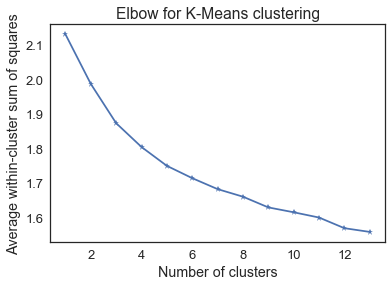

In [205]:
# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

### Choose k = 5 as best value

In [206]:
# YOUR CODE HERE
kmeans_model = skc.KMeans(n_clusters=5)
kmeans_model.fit(bob_ross[tag_columns].drop('image', axis=1))
bob_ross['cluster_labels_kmeans'] = kmeans_model.labels_
cluster1 = bob_ross[bob_ross['cluster_labels_kmeans'] == 0]
cluster2 = bob_ross[bob_ross['cluster_labels_kmeans'] == 1]
cluster3 = bob_ross[bob_ross['cluster_labels_kmeans'] == 2]
cluster4 = bob_ross[bob_ross['cluster_labels_kmeans'] == 3]
cluster5 = bob_ross[bob_ross['cluster_labels_kmeans'] == 4]

In [207]:
display_images(cluster1.image[0:7],"cluster 1")
cluster1.mean(axis=0).sort_values(ascending=False).head(5)

TREE              0.990909
MOUNTAIN          0.963636
TREES             0.954545
CONIFER           0.909091
SNOWY_MOUNTAIN    0.727273
dtype: float64

In [208]:
display_images(cluster2.image[0:7],"cluster 2")
cluster2.mean(axis=0).sort_values(ascending=False).head(5)

cluster_labels_kmeans    1.000000
TREE                     1.000000
RIVER                    0.975904
TREES                    0.951807
DECIDUOUS                0.807229
dtype: float64

In [209]:
display_images(cluster3.image[0:7],"cluster 3")
cluster3.mean(axis=0).sort_values(ascending=False).head(8)

cluster_labels_kmeans    2.000000
CLOUDS                   0.782609
OCEAN                    0.739130
WAVES                    0.695652
BEACH                    0.565217
ROCKS                    0.434783
CUMULUS                  0.326087
SUN                      0.217391
dtype: float64

In [210]:
display_images(cluster4.image[0:7],"cluster 4")
cluster4.mean(axis=0).sort_values(ascending=False).head(5)

cluster_labels_kmeans    3.000000
TREE                     1.000000
SNOW                     0.983051
WINTER                   0.949153
TREES                    0.915254
dtype: float64

In [211]:
display_images(cluster5.image[0:7],"cluster 5")
cluster5.mean(axis=0).sort_values(ascending=False).head(7)

cluster_labels_kmeans    4.0000
TREE                     1.0000
TREES                    0.9000
DECIDUOUS                0.8875
LAKE                     0.6375
GRASS                    0.5250
STRUCTURE                0.4000
dtype: float64

<span style="color:red">Qualitiative descriptions:</span>

* <span style="color:red"> Cluster 1: a cabin in the snowy winter
* <span style="color:red">Cluster 2: trees and a river with a snowy mountain in the background
* <span style="color:red">Cluster 3: decidous trees with a lake and a structure
* <span style="color:red">Cluster 4: beach and ocean waves with clouds
* <span style="color:red">Cluster 5: decidous trees with a river and conifer

### 5) k-means based on colors
Perform k-means clustering on the paintings using *only* the color columns. Decide a good value for k, execute the clustering, display the images in each clusters, and describe what is in the clusters you picked.

### <span style="color:red">NOTE TO INSTRUCTOR: NO COLORS ARE RENDERING!!</span>

In [212]:
bob_ross[color_columns].head()

c0 c1 c2 c3 c4 c5 c6 c7 c8 c9               ...               c76 c77  \
EPISODE                                             ...                         
S01E01   0  0  0  0  0  0  0  0  0  0               ...                 0   0   
S01E02   0  0  0  0  0  0  0  0  0  0               ...                 0   0   
S01E03   0  0  0  0  0  0  0  0  0  0               ...                 0   0   
S01E04   0  0  0  0  0  0  0  0  0  0               ...                 0   0   
S01E05   0  0  0  0  0  0  0  0  0  0               ...                 0   0   

        c78 c79 c80 c81 c82 c83 c84                           image  
EPISODE                                                              
S01E01    0   0   0   0   0   0   0  images/a_walk_in_the_woods.png  
S01E02    0   0   0   0   0   0   0          images/mt_mckinley.png  
S01E03    0   0   0   0   0   0   0         images/ebony_sunset.png  
S01E04    0   0   0   0   0   0   0          images/winter_mist.png  
S01E05    0   0   0   0   0   0   0         images/quiet_stream.png  

[5 rows x 86 columns]

In [213]:
bob_ross[color_columns].mean().head()

c0    0.0
c1    0.0
c2    0.0
c3    0.0
c4    0.0
dtype: float64

In [214]:
sum(bob_ross[color_columns].mean() > 0)

0

In [216]:
# YOUR CODE HERE
kmeans_model = skc.KMeans(n_clusters=5)
kmeans_model.fit(bob_ross[color_columns].drop('image', axis=1))
kmeans_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

### <span style="color:red">WITHOUT ANY COLORS, ALL IMAGES ARE BEING CLUSTERED TOGETHER INTO 1 CLUSTER</span>

In [222]:
bob_ross['cluster_labels_kmeans'] = kmeans_model.labels_
cluster1 = bob_ross[bob_ross['cluster_labels_kmeans'] == 0]
cluster2 = bob_ross[bob_ross['cluster_labels_kmeans'] == 1]
cluster3 = bob_ross[bob_ross['cluster_labels_kmeans'] == 2]
cluster4 = bob_ross[bob_ross['cluster_labels_kmeans'] == 3]
cluster5 = bob_ross[bob_ross['cluster_labels_kmeans'] == 4]

In [223]:
display_images(cluster1.image[0:7],"cluster 1")
cluster1.mean(axis=0).sort_values(ascending=False).head(5)

TREE         0.888889
TREES        0.830688
DECIDUOUS    0.558201
CONIFER      0.518519
CLOUDS       0.447090
dtype: float64

In [224]:
display_images(cluster2.image[0:7],"cluster 2")
cluster2.mean(axis=0).sort_values(ascending=False).head(5)

TITLE             NaN
APPLE_FRAME       NaN
AURORA_BOREALIS   NaN
BARN              NaN
BEACH             NaN
dtype: float64

In [225]:
display_images(cluster3.image[0:7],"cluster 3")
cluster3.mean(axis=0).sort_values(ascending=False).head(8)

TITLE             NaN
APPLE_FRAME       NaN
AURORA_BOREALIS   NaN
BARN              NaN
BEACH             NaN
BOAT              NaN
BRIDGE            NaN
BUILDING          NaN
dtype: float64

In [226]:
display_images(cluster4.image[0:7],"cluster 4")
cluster4.mean(axis=0).sort_values(ascending=False).head(5)

TITLE             NaN
APPLE_FRAME       NaN
AURORA_BOREALIS   NaN
BARN              NaN
BEACH             NaN
dtype: float64

In [227]:
display_images(cluster5.image[0:7],"cluster 5")
cluster5.mean(axis=0).sort_values(ascending=False).head(7)

TITLE             NaN
APPLE_FRAME       NaN
AURORA_BOREALIS   NaN
BARN              NaN
BEACH             NaN
BOAT              NaN
BRIDGE            NaN
dtype: float64

Qualitiative descriptions:
* Cluster 0: 
* Cluster 1:
* Cluster 2:
* ...

### <span style="color:red">^ UNABLE TO COMPLETE WITHOUT COLOR VALUES</span>

### 6) Use both tags and colors for k-means clustering

Perform k-means clustering on the paintings using *both* tag and color columns. Decide a good value for k, execute the clustering, display the images in each clusters, and describe what is in the clusters you picked.

In [242]:
# generate different k-means for every k
X = bob_ross.drop(['TITLE','image','cluster_labels_kmeans'],axis=1).copy()
K = range(1,int(k))

In [243]:
K

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [244]:
# create one model for each k
kmeans_models = [skc.KMeans(k).fit(X) for k in K]

# find the centroids for each model
centroids = [m.cluster_centers_ for m in kmeans_models]

# calculate the distance of every point
D_k = [spd.cdist(X,cent,'euclidean') for cent in centroids]

# find the min distance
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

# calculate sum of squares
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

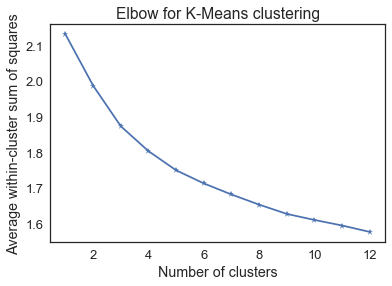

In [245]:
# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

### Choose k = 5 as best value

In [248]:
# YOUR CODE HERE
kmeans_model = skc.KMeans(n_clusters=5)
kmeans_model.fit(X)
bob_ross['cluster_labels_kmeans'] = kmeans_model.labels_
cluster1 = bob_ross[bob_ross['cluster_labels_kmeans'] == 0]
cluster2 = bob_ross[bob_ross['cluster_labels_kmeans'] == 1]
cluster3 = bob_ross[bob_ross['cluster_labels_kmeans'] == 2]
cluster4 = bob_ross[bob_ross['cluster_labels_kmeans'] == 3]
cluster5 = bob_ross[bob_ross['cluster_labels_kmeans'] == 4]

In [249]:
display_images(cluster1.image[0:7],"cluster 1")
cluster1.mean(axis=0).sort_values(ascending=False).head(5)

TREE              0.990566
MOUNTAIN          0.971698
TREES             0.952830
CONIFER           0.905660
SNOWY_MOUNTAIN    0.745283
dtype: float64

In [250]:
display_images(cluster2.image[0:7],"cluster 2")
cluster2.mean(axis=0).sort_values(ascending=False).head(5)

cluster_labels_kmeans    1.000000
CLOUDS                   0.782609
OCEAN                    0.739130
WAVES                    0.695652
BEACH                    0.565217
dtype: float64

In [251]:
display_images(cluster3.image[0:7],"cluster 3")
cluster3.mean(axis=0).sort_values(ascending=False).head(8)

cluster_labels_kmeans    2.000000
TREE                     1.000000
SNOW                     0.982759
WINTER                   0.948276
TREES                    0.931034
CONIFER                  0.758621
DECIDUOUS                0.534483
STRUCTURE                0.482759
dtype: float64

In [252]:
display_images(cluster4.image[0:7],"cluster 4")
cluster4.mean(axis=0).sort_values(ascending=False).head(5)

cluster_labels_kmeans    3.000000
TREE                     1.000000
RIVER                    0.977011
TREES                    0.942529
DECIDUOUS                0.793103
dtype: float64

In [253]:
display_images(cluster5.image[0:7],"cluster 5")
cluster5.mean(axis=0).sort_values(ascending=False).head(7)

cluster_labels_kmeans    4.000000
TREE                     1.000000
TREES                    0.901235
DECIDUOUS                0.876543
LAKE                     0.629630
GRASS                    0.518519
STRUCTURE                0.395062
dtype: float64

<span style="color:red">Qualitiative descriptions:</span>

* <span style="color:red"> Cluster 1: a cabin in the snowy winter
* <span style="color:red">Cluster 2: trees and a river with a snowy mountain in the background
* <span style="color:red">Cluster 3: decidous trees with a lake and a structure
* <span style="color:red">Cluster 4: beach and ocean waves with clouds
* <span style="color:red">Cluster 5: decidous trees with a river and conifer

### <span style="color:red">^ NOTE: with all the colors as 0, the results were the same as for the tags section</span>